<a href="https://colab.research.google.com/github/PauloVictorFS/fastaiOnCampus/blob/main/Paulo_Victor_Fonseca_211043718.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Classificação de Emoções em Imagens

Aluno: Paulo Victor Fonseca Sousa

Matricula:211043718

Github:PauloVictorFS

##Introdução

O projeto a seguir foi realizado para a disciplina de Aprendizado de Maquina e  tem como objetivo explorar o aprendizado de máquina aplicado à classificação de imagens. A tarefa principal será treinar um modelo de aprendizado profundo capaz de distinguir entre expressões faciais felizes e tristes em imagens. Esse projeto foi organizado conforme   as diretrizes específicas apresentadas pelo professor, que serão definidas a seguir:
## Critérios do projeto:
- Propósito: O projeto tem como propósito principal a criação de um modelo de aprendizado de máquina para classificar expressões faciais em imagens como "felizes" ou "tristes". O objetivo é aplicar técnicas de aprendizado profundo para resolver essa tarefa.

- Tema Abordado na Lição: O projeto está alinhado com os conceitos e técnicas apresentados na lição do Fastai relacionada ao aprendizado profundo e classificação de imagens.

- Dado Coerente com o Tema: Os dados utilizados para treinar e testar o modelo são imagens de pessoas com expressões faciais felizes e tristes. Isso está em conformidade com a tarefa de classificação de emoções em imagens.

- Caracterização do Dado: Os dados são coletados da web usando a API do DuckDuckGo e passam por um processo de verificação manual de qualidade antes de serem usados para treinamento do modelo. O fluxo de aquisição e pré-processamento dos dados será detalhado.

- Organização: O projeto é organizado em células de código que executam tarefas específicas, desde a aquisição de dados até a criação, treinamento e avaliação do modelo. Isso proporciona uma estrutura clara para compreender o fluxo de trabalho. Cada célula será explicada de forma detalhada

- Jupyter: O projeto é elaborado usando um ambiente Jupyter Notebook, o que permite documentar as etapas do projeto e executar código interativamente.


### Célula 1:
Esta célula instala dois pacotes Python, "duckduckgo_search" e "fastai", usando o comando pip install. Esses pacotes são necessários para as tarefas subsequentes no projeto.

In [ ]:
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00


### Célula 2
 Nesta célula, é realizado a importação de  funções do pacote "duckduckgo_search" e definido uma função chamada search_images. Essa função permite buscar e coletar URLs de imagens relacionadas a um termo específico usando a API do DuckDuckGo.

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=300): return L(ddg_images(term, max_results=max_images)).itemgot('image')

 ### Célula 3 e 4
 Nestas células, são realizados os downloads de uma única imagem de uma "pessoa triste" e de uma "pessoa feliz" usando a função download_url e exibido essas imagens em miniatura. Isso é realizado para garantir que a função está funcionando conforme o esperado

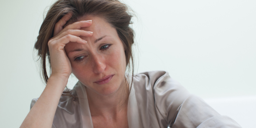

In [ ]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('sad person', max_images=1)[0], 'sad.jpg', show_progress=True)
Image.open('sad.jpg').to_thumb(256,256)

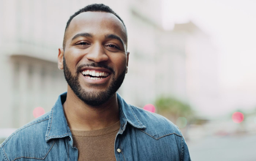

In [ ]:
download_url(search_images('happy person', max_images=1)[0], 'happy.jpg', show_progress=False)
Image.open('happy.jpg').to_thumb(256,256)

### Célula 5
Nesta célula, respectivamente, é definido uma lista de termos de busca através do 'searches' ("pessoa feliz" e "pessoa triste") e um caminho de destino("path") para armazenar as imagens baixadas. Em seguida, é executado um loop para cada termo de busca, criando uma pasta para cada um, fazendo o download de imagens relacionadas a esses termos, aguardando entre cada pesquisa e redimensionando as imagens para um tamanho máximo de 400 pixels.

In [ ]:
searches = ' pessoa feliz',' pessoa triste'
path = Path('pessoa feliz ou pessoa triste')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} 90s style'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} 80s style'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

### Célula 6
Aqui é verificado a qualidade das imagens baixadas. A função verify_images é usada para verificar se as imagens são válidas e exclui aquelas que não atendem aos critérios de qualidade.

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

24

### Célula 7
Nesta célula, é definido um bloco de dados (DataBlock) para organizar os dados de imagem. Isso envolve a definição de blocos de entrada (imagem) e saída (categoria), bem como as transformações de dados e a divisão dos dados em conjuntos de treinamento e validação.

Além disso, é  exibido um lote de imagens dos conjuntos de dados de treinamento e validação usando a função show_batch. Isso ajuda a entender como os dados estão organizados e visualmente inspecionar as imagens.

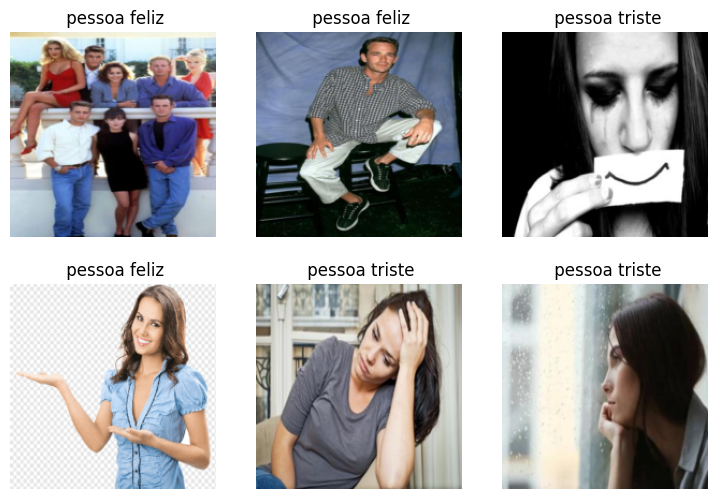

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

 ### Célula 9
Nesta célula, é criado um modelo de aprendizado de máquina para classificar imagens de expressões faciais como "felizes" ou "tristes". Primeiro, foi utilizado a função vision_learner para criar um objeto "learn" que inclui um modelo de rede neural convolucional  baseado na arquitetura "resnet18". Esse modelo pré-treinado é uma forma de transferência de aprendizado, onde aproveitamos o conhecimento prévio do modelo sobre uma ampla variedade de imagens antes de ajustá-lo especificamente para nosso problema de classificação de emoções.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.187133,0.603543,0.254902,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.465902,0.400083,0.127451,01:01
1,0.334770,0.555606,0.176471,00:55
2,0.245642,0.593529,0.186275,00:55


### Célula 10 e 11
Nesta célula, é utilizado o modelo de aprendizado de máquina treinado anteriormente (resnet18) para fazer uma previsão sobre uma imagem de uma "pessoa triste" (imagem 'sad.jpg') e de uma "pessoa feliz"(imagem 'happy.jpg'.) A probabilidade da imagem ser classificada como "feliz"  é exibida.

In [ ]:
is_happy,_,probs = learn.predict(PILImage.create('sad.jpg'))
print(f" {is_happy}.")
print(f"Probabilidade de estar feliz: {probs[0]:.4f}")

This person looks : pessoa triste.
Probability it's happy: 0.0002


In [ ]:
is_happy,_,probs = learn.predict(PILImage.create('happy.jpg'))
print(f" {is_happy}.")
print(f"Probabilidade de estar feliz: {probs[0]:.4f}")